In [254]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [255]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [256]:
len(words)

32033

In [257]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [258]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [259]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [260]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 2000), generator=g)
b1 = torch.randn(2000, generator=g)
W2 = torch.randn((2000, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [261]:
sum(p.nelement() for p in parameters)

68081

In [262]:
for p in parameters:
    p.requires_grad = True

In [263]:
lossi = []
stepi = []

for i in range(3000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # sample 32 at a time
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27])
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    if i > 500:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.item())

78.27950286865234
59.89234161376953
54.50031280517578
54.08624267578125
42.777183532714844
43.8504638671875
41.004608154296875
44.86316680908203
39.01286697387695
34.64649200439453
30.10330581665039
47.952999114990234
28.440448760986328
27.998926162719727
34.084232330322266
27.62697982788086
43.31136703491211
24.32500648498535
41.17680358886719
29.325210571289062
28.8781795501709
31.009706497192383
34.18115234375
23.724042892456055
31.29907989501953
27.273330688476562
27.256439208984375
26.980558395385742
21.84499740600586
17.986507415771484
30.176761627197266
33.71847915649414
17.759008407592773
28.385517120361328
29.07308578491211
32.12340545654297
24.44646453857422
42.828697204589844
19.471820831298828
37.42990493774414
37.871856689453125
31.06973648071289
43.777896881103516
24.67182159423828
22.940160751342773
29.346879959106445
40.380523681640625
25.804597854614258
32.95750045776367
32.73957443237305
24.380205154418945
25.448633193969727
24.660938262939453
26.36362648010254
26.487

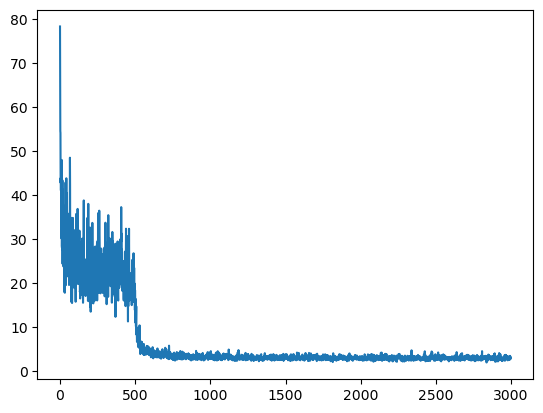

In [264]:
plt.plot(stepi, lossi)

In [265]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27])
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.7590, grad_fn=<NllLossBackward0>)

In [266]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27])
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.7551, grad_fn=<NllLossBackward0>)

In [267]:


# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

texba.
pemakuraila.
kayha.
panimi.
tainrakayk.
kavaa.
paavyabajtahri.
paav.
mazian.
kaugi.
pardagan.
paramsaday.
akaviyny.
kabs.
mhin.
venvtahlasa.
jadra.
anwil.
paanaivan.
japannin.


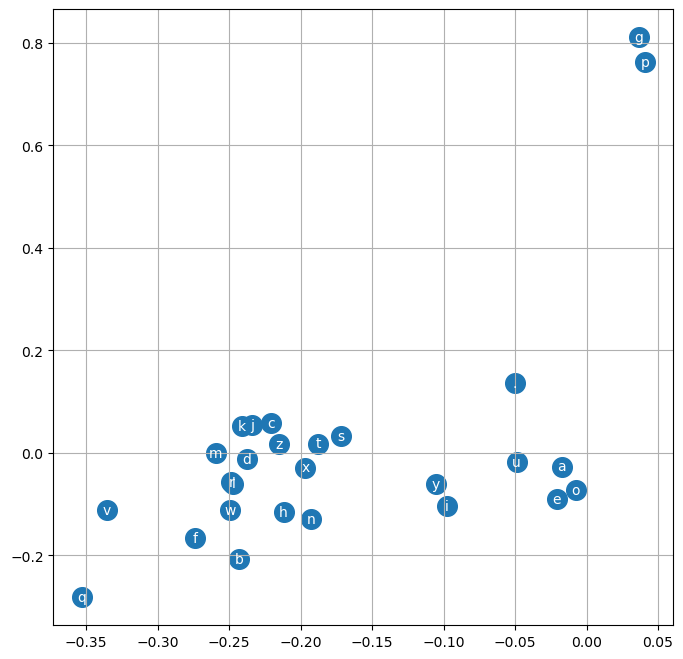

In [268]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# notice that vowels are together, so they can be used interchangeably